
# Web Mining - Project : #

***

## Objective : 

<p>
Mining twitter data for discovering what topics Indians are discussing in the recent times.  

- Use LDA (Latent Dirichlet Allocation) or other topic identification techniques.

- Provide a deep analysis.
</p>

***
</br>

## Importing required libraries :


In [1]:
import numpy as np
import pandas as pd 
import re

import gensim
from gensim import corpora, models, similarities
from gensim.parsing.preprocessing import STOPWORDS
from nltk.corpus import stopwords

home = '../input/twitterrecentindia/'

# Processing tweets with NLP #

***

#### *The steps we followed to process the stored Tweets are:*

- *a)* Delete unnecessary data: usernames,emails,hyperlinks, retweets, punctuation, duplicate characters, and special characters like emoticons.

- *b)* Normalize whitespace (convert multiple sequential whitespace chars into one whitespace character).

- *c)* Convert hashtags into separate words, for example, thehashtag #IndianMedia is converted into two words, Indian and Media.

- *d)* Create a function to translate the given language to english

- *e)* Create a function for automatic correction of spelling mistakes.

- *f)* Create a list of contractions to normalize and expand words. For example: What's=>What is

- *g)* Delete the suffix of a word until we find the root. For example: Stemming => stem

- *h)* Remove english, hindi, hinglish stopwords


## A) Delete unnecessary data: usernames, emails, hyperlinks, punctuation, duplicate characters, and special characters like smileys (emoji). ##

In [2]:
# first to detect the types of emoji and to eliminate them we use the demoji library from https://pypi.org/project/demoji/
!pip install demoji

import demoji
demoji.download_codes()

... OK (Got response in 0.25 seconds)
Writing emoji data to /root/.demoji/codes.json ...
... OK


In [3]:
'''Using the Downloaded demoji data to remove emojis from the text'''
df = pd.read_json(home + 'demoji.json')
df

,timestamp,codes
#⃣,2019-12-30 15:26:02.615219200,keycap: #
#️⃣,2019-12-30 15:26:02.615219200,keycap: #
*⃣,2019-12-30 15:26:02.615219200,keycap: *
*️⃣,2019-12-30 15:26:02.615219200,keycap: *
0⃣,2019-12-30 15:26:02.615219200,keycap: 0
...,...,...
🪑,2019-12-30 15:26:02.615219200,chair
🪒,2019-12-30 15:26:02.615219200,razor
🪓,2019-12-30 15:26:02.615219200,axe
🪔,2019-12-30 15:26:02.615219200,diya lamp


In [4]:
demoji_df = pd.read_json(home + 'demoji.json', encoding='utf-8') # from https://pypi.org/project/demoji/
demoji_df.reset_index(inplace=True)
demoji_df.astype({"index": str})

def delete_unnecessary_data(tweet):
    #delete @username
    tweet = re.sub('@[^\s]+','',tweet)
    
    #delete www.* or https?://* 
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet)
    
    #delete username
    tweet = re.sub('username[^\s]+','',tweet)
    
    #delete emails
    tweet = re.sub('[^\s@]+@[^\s@]+',' ',tweet)

    #delete javascript tags
    tweet =re.sub('< *script*>.*?< *script*>',' ',tweet)
    
    #delete all html tags
    tweet = re.sub('<.*?>',' ',tweet)
    
    #delete numbers 
    tweet = re.sub("[0-9><,]+"," ",tweet)
    
    #delete blank line
    tweet = re.sub(r"\n+|┊"," ",tweet)

    #delete duplicate characters
    tweet = re.sub(r"(.)\1{2,}", r"\1\1", tweet)
    
    #Remove special characters like smileys (imojie)
    '''
    😂🤷‍♀️❤️🔴📢✅❎🥘↘️🌻♥️♥️♥️🥵🆚📅🕗📍👋😩😢🙌🏾🔥😮💖😭👄❤🤢💥💣
    🎄❤❤🐪🐱💰🏷⭐🙄😍🙌👇💚😭😹🌸💛🙏👏😔🎁🥰❄🎄💤
    '''     
    for code in demoji_df["index"]:
        try:
            tweet = re.sub(code, '', tweet)
        except:
            pass
        
    return tweet

**Testing our function**

In [5]:
text = "@abc tu kya kar rha tha 😂😂😂😉😉"
# text =' ┊ test'

print("Text Before: ",text)
text = delete_unnecessary_data(text)
print("Text After: ",text)

Text Before:  @abc tu kya kar rha tha 😂😂😂😉😉
Text After:   tu kya kar rha tha 


## B) Normalize whitespace (convert multiple sequential whitespace chars into one whitespace character). ##

In [6]:
def normalize_whitespace(tweet):
    tweet = re.sub('[\s]+', ' ', tweet)
    return tweet

**Testing our Funtion**

In [7]:
text = "         dhaskdjhaskdabsdba l lkad.    ljdald. "
print("Text Before: ",text)
text = normalize_whitespace(text)
print("Text After: ",text)

Text Before:           dhaskdjhaskdabsdba l lkad.    ljdald. 
Text After:   dhaskdjhaskdabsdba l lkad. ljdald. 


## C) Convert hashtags into separate words

In [8]:
def sp_h(hashtag_string):
    fo = re.compile(r'#[A-Z]{2,}(?![a-z])|[A-Z][a-z]+')
    fi = fo.findall(hashtag_string)
    return ' '.join(fi)

def split_hashtag(tweet):
    tweet = re.sub(r'#[^\s]+', lambda m: sp_h(m.group()), tweet)  #CovidCrisis => Covid Crisis
    return tweet

In [9]:
def remove_punctuation(tweet):
    tweet = re.sub('[^\w\s\']',' ',tweet)
    return tweet

**Testing our funtion**

In [10]:
text = "#CovidCrisis"
print("Text Before: ",text)
text = split_hashtag(text);
print("Text After: ",text)

Text Before:  #CovidCrisis
Text After:  Covid Crisis


## D) Creating a function to translate the text to English. ##

In [11]:
# !pip install googletrans==3.1.0a0
import googletrans
from googletrans import Translator

def translate_to_english(tweet):
    translator = Translator()
    tweet = translator.translate(tweet).text
    return tweet

     |████████████████████████████████| 55 kB 657 kB/s eta 0:00:01
     |████████████████████████████████| 133 kB 1.7 MB/s eta 0:00:01
     |████████████████████████████████| 994 kB 3.6 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 771 kB/s eta 0:00:01
     |████████████████████████████████| 53 kB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 1.7 MB/s eta 0:00:011
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16368 sha256=238e6576780d8455338a502bf6a60db31ad9f7c65ace383b2c982b298fb6aa0c
  Stored in directory: /root/.cache/pip/wheels/0c/be/fe/93a6a40ffe386e16089e44dad9018ebab9dc4cb9eb7eab65ae
Successfully built googletrans
  Attempting uninstall: chardet
    Found existing installation: chardet 4.0.0
    Uninstalling chardet-4.0.0:
      Successfully uninstalled chardet-4.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of 

**Testing our function**

In [12]:
text = "ಜಂಗಮಕ್ಕೆ ಅರಿವ ಮರೆದಾಗಲೆ ಅಪಮಾನ ಹೋಯಿತ್ತು"
# text = "My name is Ishan"
text = translate_to_english(text)
print(text)

As soon as you realize the problem, there is disgrace


## D) Create a function for automatic correction of spelling mistakes. ##

In [14]:
# !pip install autocorrect
from autocorrect import Speller
spell = Speller(lang='en')

def correct_en(text):
    #convert to lower case
    text = text.lower()
    # Clean the text
    text = re.sub("\'s ", " is", text) # we have cases like "Sam is" or "Sam's" (i.e. his) these two cases aren't separable, I choose to compromise are kill "'s" directly
    text = re.sub(r" whats ", " what is ", text, flags=re.IGNORECASE)
    text = re.sub("\'ve", " have ", text)
    text = re.sub("n\'t", " not ", text)
    text = re.sub("i'm", "i am", text, flags=re.IGNORECASE)
    text = re.sub("\'re", " are ", text)
    text = re.sub("\'d", " would ", text)
    text = re.sub("\'ll", " will ", text)
    text = re.sub("e-mail", " email ", text, flags=re.IGNORECASE)
    text = re.sub("\(s\)", " ", text, flags=re.IGNORECASE) #mester(s)
    text = re.sub(r" (the[\s]+|The[\s]+)?(us(a)?|u\.s\.(a\.)?|united state(s)?) ", " america ", text)
    text = re.sub(r" uk ", " england ", text, flags=re.IGNORECASE)
    text = re.sub(r" imrovement ", " improvement ", text, flags=re.IGNORECASE)
    text = re.sub(r" intially ", " initially ", text, flags=re.IGNORECASE)
    text = re.sub(r" dms ", " direct messages ", text, flags=re.IGNORECASE)  
    text = re.sub(r" demonitization ", " demonetization ", text, flags=re.IGNORECASE) 
    text = re.sub(r" actived ", " active ", text, flags=re.IGNORECASE)
    text = re.sub(r" kms ", " kilometers ", text, flags=re.IGNORECASE)
    text = re.sub(r" cs ", " computer science ", text, flags=re.IGNORECASE)
    text = re.sub(r" calender ", " calendar ", text, flags=re.IGNORECASE)
    text = re.sub(r" ios ", " operating system ", text, flags=re.IGNORECASE)
    text = re.sub(r" programing ", " programming ", text, flags=re.IGNORECASE)
    text = re.sub(r" bestfriend ", " best friend ", text, flags=re.IGNORECASE)
    text = re.sub(r"bn8|god8" ,'good night', text, flags=re.IGNORECASE)
    text = re.sub(r" 2moro | 2mrrw | 2morrow | 2mrw | tomrw ", " tomorrow ", text)
    text = re.sub(r" b4 ", " before ", text)
    text = re.sub(r" otw ", " on the way ", text)

    text = spell(text)

    return text

     |████████████████████████████████| 622 kB 1.3 MB/s eta 0:00:01
  Created wheel for autocorrect: filename=autocorrect-2.5.0-py3-none-any.whl size=621854 sha256=80e9d2331fbdc2c78a2abd951d256dc2dbe2333cb14d612bebba310708fa3971
  Stored in directory: /root/.cache/pip/wheels/3d/8e/bd/f6fd900a056a031bf710a00bca338d86f43b83f0c25ab5242f
Successfully built autocorrect


## Building our Model

### Stopwords Removal

In [15]:
import gensim
from gensim.parsing.preprocessing import STOPWORDS
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

hinglish_stop_words = []
with open('../input/twitterrecentindia/stop_hinglish.txt','r') as f:
    for line in f:
           hinglish_stop_words.append(f.readline().rstrip('\n'))
    
hindi_stop_words = []
with open('../input/twitterrecentindia/stop_hindi.txt','r') as f:
    for line in f:
           hindi_stop_words.append(f.readline().rstrip('\n'))

# print(hindi_stop_words)


stop_words.extend(hindi_stop_words)
stop_words.extend(hinglish_stop_words)


### Stemming ##

In [16]:
import nltk
# nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer

stemmer = PorterStemmer()

def tokenize_stemming(text):
    text = re.sub(r'[^\w\s]','',text)
    #replace multiple spaces with one space
    text = re.sub(r'[\s]+',' ',text)
    #transfer text to lowercase
    text = text.lower() 
    # tokenize text
    tokens = re.split(" ", text)

    # Remove stop words 
    result = []
    for token in tokens :
        if token not in stop_words and len(token) > 1:
            result.append(stemmer.stem(token))

    return result

### Combining all the preprocessing

In [17]:
def preprocess(tweet):
    tweet = translate_to_english(tweet)
    tweet = delete_unnecessary_data(tweet)
    tweet = normalize_whitespace(tweet)
    tweet = split_hashtag(tweet)
    tweet = remove_punctuation(tweet)
    tweet = correct_en(tweet)
    tokens = tokenize_stemming(tweet)
    return tokens

**Testing Preprocessing**

In [18]:
tweet = "Main yaha jaana chahta hu"

preprocess(tweet)

['want', 'go']

### Loading the data
***

In [19]:
df = pd.read_csv('../input/twitterrecentindia/twitter_data.csv')
df

,Unnamed: 0,date,content
0,0,2021-05-04 17:43:12+00:00,@pta_nahin Finally you got it lol
1,1,2021-05-04 17:43:12+00:00,🤣🤣🤣 https://t.co/DIC1DbFbPQ
2,2,2021-05-04 17:43:12+00:00,Illusion or reality? https://t.co/vyaXvulNDK
3,3,2021-05-04 17:43:12+00:00,@i_am_IBBU follow me ifb https://t.co/HJ6H7buMTx
4,4,2021-05-04 17:43:12+00:00,@wattal_pooja 🙏😊
...,...,...,...
5995,5995,2021-05-04 17:36:56+00:00,@RumiTweets_ Musa.Alehisalaam....
5996,5996,2021-05-04 17:36:56+00:00,@Alibhatti7642 Duain
5997,5997,2021-05-04 17:36:56+00:00,@thakkar_sameet कपिल मिश्रा को बस एक महीने को ...
5998,5998,2021-05-04 17:36:56+00:00,@AzharNazir0055 Issi m tu mzza😂😂😂😂


In [20]:
df = df['content']
df 

0                       @pta_nahin Finally you got it lol
1                             🤣🤣🤣 https://t.co/DIC1DbFbPQ
2            Illusion or reality? https://t.co/vyaXvulNDK
3        @i_am_IBBU follow me ifb https://t.co/HJ6H7buMTx
4                                        @wattal_pooja 🙏😊
                              ...                        
5995                    @RumiTweets_ Musa.Alehisalaam....
5996                                 @Alibhatti7642 Duain
5997    @thakkar_sameet कपिल मिश्रा को बस एक महीने को ...
5998                   @AzharNazir0055 Issi m tu mzza😂😂😂😂
5999    🙏🙏🙏🙏...@sunilyadv_unnao @yadavakhilesh @Brajes...
Name: content, Length: 6000, dtype: object

In [21]:
# df.apply(lambda x: preprocess(x))

### Preprocessing all the tweets

In [22]:
tokens = []
for tweet in df:
    tokens.append(preprocess(tweet))

In [23]:
tokens[0:5]

[['final', 'lol'], [], ['illus', 'realiti'], ['follow'], []]

# How to create Topic Models with LDA? #

***

<p>
The objective of topic models is to extract the underlying topics from a given collection of text documents. Each document in the text is considered as a combination of topics and each topic is considered as a combination of related words.
</p>

<p>
Topic modeling can be done by algorithms like Latent Dirichlet Allocation (LDA) and Latent Semantic Indexing (LSI).
</p>

<p>
In both cases you need to provide the number of topics as input. The topic model, in turn, will provide the topic keywords for each topic and the percentage contribution of topics in each document.
</p>

<p>
The quality of topics is highly dependent on the quality of text processing and the number of topics you provide to the algorithm. The earlier post on how to build best topic models explains the procedure in more detail. However, I recommend understanding the basic steps involved and the interpretation in the example below.
</p>
</br>

*References*: 
* https://www.machinelearningplus.com/nlp/gensim-tutorial/
* https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
* https://github.com/susanli2016/NLP-with-Python/blob/master/LDA_news_headlines.ipynb

In [24]:
dictionary = corpora.Dictionary(tokens)
print(dictionary)
print(dictionary.num_docs)

Dictionary(9395 unique tokens: ['final', 'lol', 'illus', 'realiti', 'follow']...)
6000


We have successfully created a Dictionary object. Gensim will use this dictionary to create a bag-of-words corpus where the words in the documents are replaced with its respective id provided by this dictionary.

## Term Frequency

In [25]:
corpus_doc2bow_vectors = [dictionary.doc2bow(tok_doc) for tok_doc in tokens]
print("# Term Frequency : ")
corpus_doc2bow_vectors[:5]

# Term Frequency : 


[[(0, 1), (1, 1)], [], [(2, 1), (3, 1)], [(4, 1)], []]

## TF-IDF

In [26]:
tfidf_model = models.TfidfModel(corpus_doc2bow_vectors, id2word=dictionary, normalize=False)
corpus_tfidf_vectors = tfidf_model[corpus_doc2bow_vectors]

print("\n\n# TF_IDF : ")
print(corpus_tfidf_vectors[5])



# TF_IDF : 
[(5, 10.228818690495881), (6, 12.550746785383243), (7, 7.906890595608519), (8, 6.878321443411748), (9, 9.74339186332564), (10, 12.550746785383243), (11, 8.091315166745947), (12, 8.463283944132904), (13, 9.965784284662087), (14, 8.027184829326231), (15, 9.550746785383243), (16, 8.091315166745947)]


## Running LDA using Bag of Words

Train our lda model using gensim.models.LdaMulticore and save it to ‘lda_model’

In [27]:
lda_model = gensim.models.LdaMulticore(corpus_doc2bow_vectors, num_topics=10, id2word=dictionary, passes=2, workers=2)

For each topic, we will explore the words occuring in that topic and its relative weight.

In [28]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.008*"patient" + 0.008*"hospit" + 0.006*"ki" + 0.006*"जय" + 0.005*"sir" + 0.005*"hai" + 0.004*"time" + 0.004*"good" + 0.004*"bed" + 0.004*"govern"
Topic: 1 
Words: 0.007*"hai" + 0.006*"ہے" + 0.005*"ye" + 0.005*"covid" + 0.005*"time" + 0.004*"سے" + 0.004*"get" + 0.004*"done" + 0.004*"add" + 0.004*"rant"
Topic: 2 
Words: 0.021*"bengal" + 0.016*"hai" + 0.009*"student" + 0.008*"सरक" + 0.008*"anti" + 0.008*"और" + 0.007*"violenc" + 0.007*"रह" + 0.007*"burn" + 0.007*"नह"
Topic: 3 
Words: 0.045*"नह" + 0.035*"सकत" + 0.010*"हत" + 0.007*"अपन" + 0.007*"लन" + 0.005*"बदल" + 0.005*"यकर" + 0.005*"पक" + 0.005*"tha" + 0.005*"जनवर"
Topic: 4 
Words: 0.015*"पर" + 0.012*"follow" + 0.009*"रह" + 0.009*"नह" + 0.009*"کے" + 0.006*"करन" + 0.006*"back" + 0.006*"نہیں" + 0.006*"हम" + 0.005*"अपन"
Topic: 5 
Words: 0.015*"hai" + 0.007*"ho" + 0.007*"नह" + 0.007*"सकत" + 0.007*"ka" + 0.005*"anti" + 0.005*"kia" + 0.005*"sir" + 0.004*"main" + 0.004*"रह"
Topic: 6 
Words: 0.013*"covid" + 0.009*"hai" + 0.008*

### Distinguish between different topics using the words in each topic and the corresponding weights

## Running LDA using TF-IDF

In [29]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf_vectors, num_topics=10, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.010*"follow" + 0.007*"वर" + 0.005*"back" + 0.005*"rant" + 0.005*"रह" + 0.005*"hai" + 0.004*"नह" + 0.004*"ok" + 0.004*"shit" + 0.004*"सब"
Topic: 1 Word: 0.005*"हर" + 0.004*"पर" + 0.004*"govern" + 0.004*"bengal" + 0.003*"hai" + 0.003*"gt" + 0.003*"congratul" + 0.003*"video" + 0.003*"share" + 0.003*"रह"
Topic: 2 Word: 0.005*"bengal" + 0.005*"arrest" + 0.005*"main" + 0.004*"mapdata" + 0.004*"sir" + 0.004*"hai" + 0.004*"tha" + 0.004*"kia" + 0.003*"data" + 0.003*"hospit"
Topic: 3 Word: 0.006*"रह" + 0.006*"सन" + 0.005*"hai" + 0.004*"रत" + 0.004*"लग" + 0.003*"सम" + 0.003*"ki" + 0.003*"और" + 0.003*"away" + 0.003*"covid"
Topic: 4 Word: 0.007*"रह" + 0.005*"सरक" + 0.005*"bengal" + 0.005*"पर" + 0.005*"आप" + 0.005*"और" + 0.004*"इस" + 0.004*"हम" + 0.004*"amp" + 0.004*"जन"
Topic: 5 Word: 0.007*"covid" + 0.005*"onlin" + 0.005*"colleg" + 0.005*"exam" + 0.005*"affili" + 0.004*"haha" + 0.004*"oxygen" + 0.003*"america" + 0.003*"میں" + 0.003*"get"
Topic: 6 Word: 0.013*"नह" + 0.008*"और" + 0.

## Classification of the topics

### Performance evaluation by classifying sample document using LDA Bag of Words model

We will check where our test document would be classified.


In [30]:
for index, score in sorted(lda_model[corpus_doc2bow_vectors[1]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.10000000149011612	 
Topic: 0.008*"patient" + 0.008*"hospit" + 0.006*"ki" + 0.006*"जय" + 0.005*"sir" + 0.005*"hai" + 0.004*"time" + 0.004*"good" + 0.004*"bed" + 0.004*"govern"

Score: 0.10000000149011612	 
Topic: 0.007*"hai" + 0.006*"ہے" + 0.005*"ye" + 0.005*"covid" + 0.005*"time" + 0.004*"سے" + 0.004*"get" + 0.004*"done" + 0.004*"add" + 0.004*"rant"

Score: 0.10000000149011612	 
Topic: 0.021*"bengal" + 0.016*"hai" + 0.009*"student" + 0.008*"सरक" + 0.008*"anti" + 0.008*"और" + 0.007*"violenc" + 0.007*"रह" + 0.007*"burn" + 0.007*"नह"

Score: 0.10000000149011612	 
Topic: 0.045*"नह" + 0.035*"सकत" + 0.010*"हत" + 0.007*"अपन" + 0.007*"लन" + 0.005*"बदल" + 0.005*"यकर" + 0.005*"पक" + 0.005*"tha" + 0.005*"जनवर"

Score: 0.10000000149011612	 
Topic: 0.015*"पर" + 0.012*"follow" + 0.009*"रह" + 0.009*"नह" + 0.009*"کے" + 0.006*"करन" + 0.006*"back" + 0.006*"نہیں" + 0.006*"हम" + 0.005*"अपन"

Score: 0.10000000149011612	 
Topic: 0.015*"hai" + 0.007*"ho" + 0.007*"नह" + 0.007*"सकत" + 0.007*"ka" + 0.

Our test document has the highest probability to be part of the topic that our model assigned, which is the accurate classification.

</br>

### Performance evaluation by classifying sample document using LDA TF-IDF model.

In [31]:
for index, score in sorted(lda_model_tfidf[corpus_doc2bow_vectors[1]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.10000000149011612	 
Topic: 0.010*"follow" + 0.007*"वर" + 0.005*"back" + 0.005*"rant" + 0.005*"रह" + 0.005*"hai" + 0.004*"नह" + 0.004*"ok" + 0.004*"shit" + 0.004*"सब"

Score: 0.10000000149011612	 
Topic: 0.005*"हर" + 0.004*"पर" + 0.004*"govern" + 0.004*"bengal" + 0.003*"hai" + 0.003*"gt" + 0.003*"congratul" + 0.003*"video" + 0.003*"share" + 0.003*"रह"

Score: 0.10000000149011612	 
Topic: 0.005*"bengal" + 0.005*"arrest" + 0.005*"main" + 0.004*"mapdata" + 0.004*"sir" + 0.004*"hai" + 0.004*"tha" + 0.004*"kia" + 0.003*"data" + 0.003*"hospit"

Score: 0.10000000149011612	 
Topic: 0.006*"रह" + 0.006*"सन" + 0.005*"hai" + 0.004*"रत" + 0.004*"लग" + 0.003*"सम" + 0.003*"ki" + 0.003*"और" + 0.003*"away" + 0.003*"covid"

Score: 0.10000000149011612	 
Topic: 0.007*"रह" + 0.005*"सरक" + 0.005*"bengal" + 0.005*"पर" + 0.005*"आप" + 0.005*"और" + 0.004*"इस" + 0.004*"हम" + 0.004*"amp" + 0.004*"जन"

Score: 0.10000000149011612	 
Topic: 0.007*"covid" + 0.005*"onlin" + 0.005*"colleg" + 0.005*"exam" + 0.00

/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 2357 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 2352 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 2361 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 2344 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 2360 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 2348 missing from current font.
  font.set_text(s

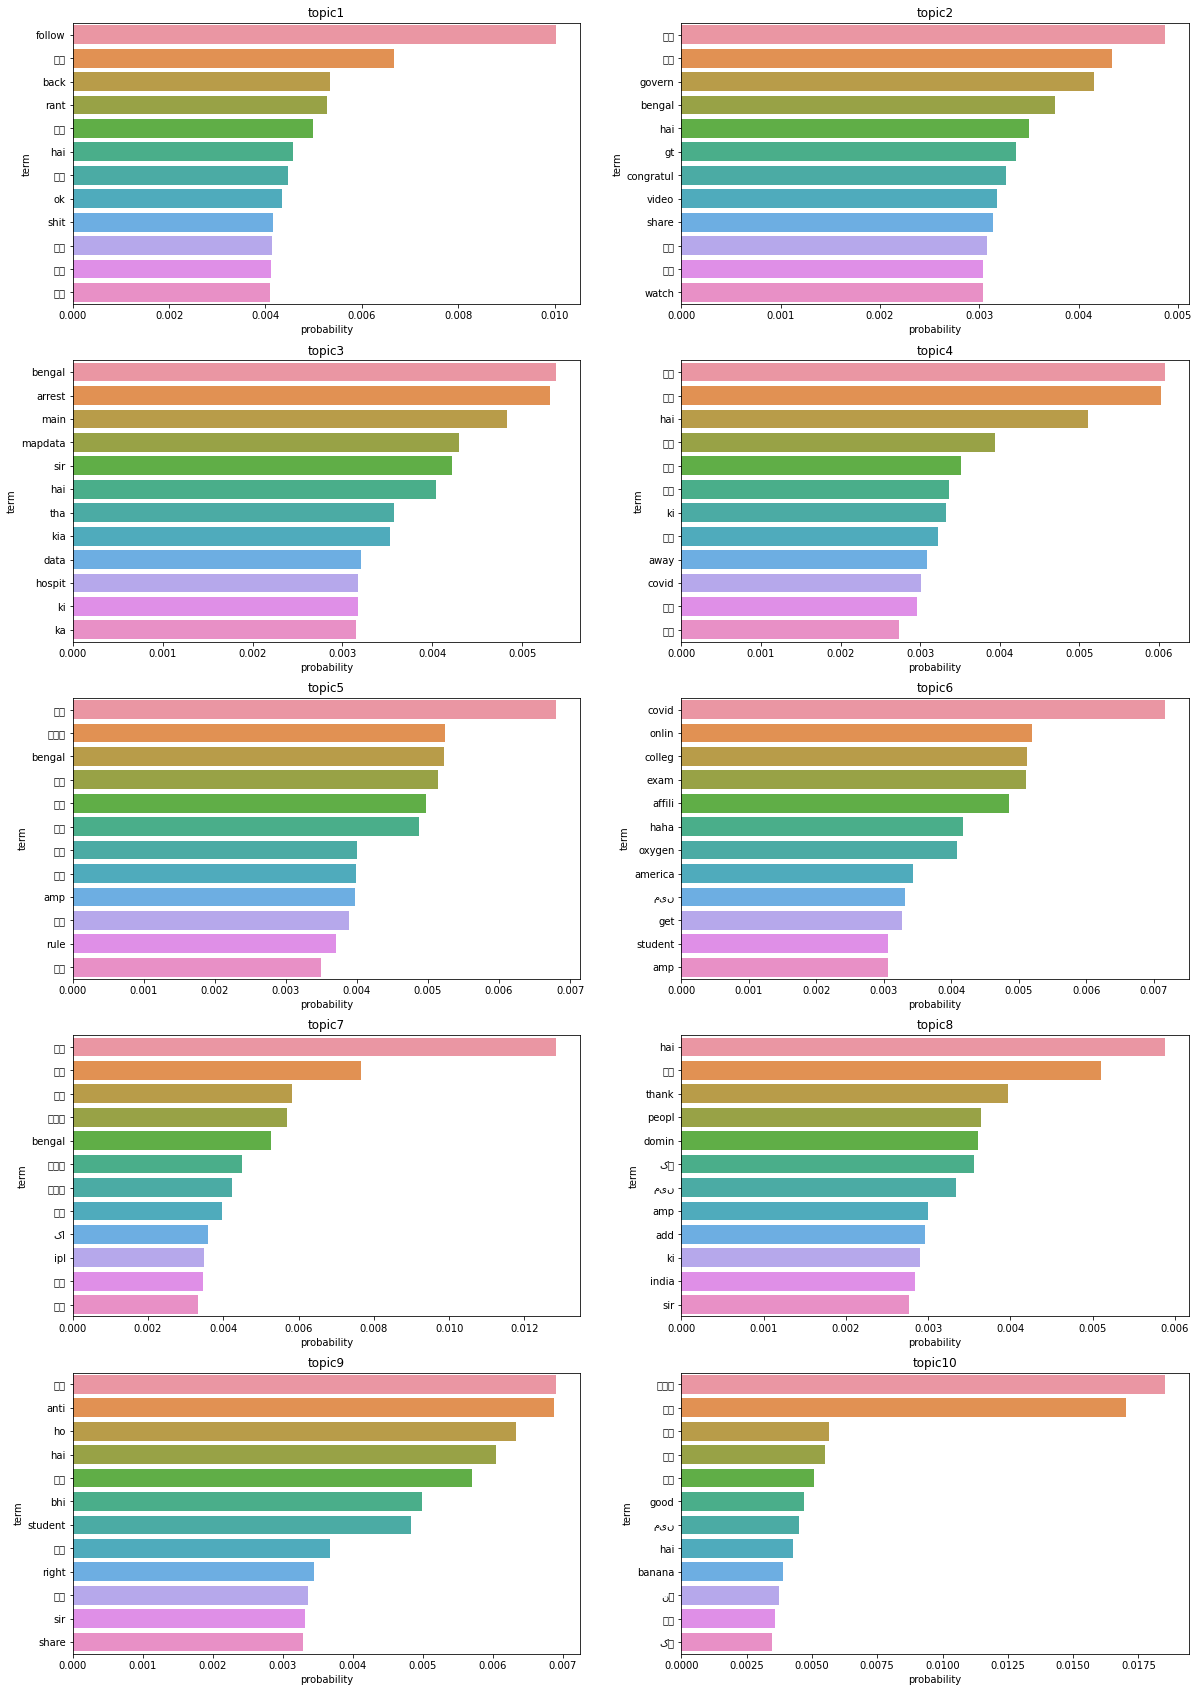

In [32]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import seaborn as sns

fig = plt.figure(figsize = (20,30))
    
for i in range(10):
    df = pd.DataFrame(lda_model_tfidf.show_topic(i,12), columns=['term','prob']).set_index('term')
    plt.subplot(5,2,i+1)
    plt.title('topic'+str(i+1))
    sns.barplot(x='prob', y=df.index, data=df)
    plt.xlabel('probability')
plt.show()

Our test document has the highest probability to be part of the topic that our model assigned, which is the accurate classification.

</br>

### Testing model on unseen document

In [34]:
unseen_document = 'Covid oxygen crisis'
bow_vector = dictionary.doc2bow(preprocess(unseen_document))
for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))

Score: 0.7749485373497009	 Topic: 0.009*"oxygen" + 0.007*"covid" + 0.007*"good" + 0.007*"hai" + 0.006*"nazi"
Score: 0.02500983327627182	 Topic: 0.013*"covid" + 0.009*"hai" + 0.008*"india" + 0.008*"shit" + 0.007*"ki"
Score: 0.025009289383888245	 Topic: 0.007*"hai" + 0.006*"ہے" + 0.005*"ye" + 0.005*"covid" + 0.005*"time"
Score: 0.025005782023072243	 Topic: 0.008*"patient" + 0.008*"hospit" + 0.006*"ki" + 0.006*"जय" + 0.005*"sir"
Score: 0.025004955008625984	 Topic: 0.045*"नह" + 0.035*"सकत" + 0.010*"हत" + 0.007*"अपन" + 0.007*"लन"
Score: 0.025004835799336433	 Topic: 0.021*"bengal" + 0.016*"hai" + 0.009*"student" + 0.008*"सरक" + 0.008*"anti"
Score: 0.025004802271723747	 Topic: 0.015*"पर" + 0.012*"follow" + 0.009*"रह" + 0.009*"नह" + 0.009*"کے"
Score: 0.025004589930176735	 Topic: 0.015*"hai" + 0.007*"ho" + 0.007*"नह" + 0.007*"सकत" + 0.007*"ka"
Score: 0.025003807619214058	 Topic: 0.023*"रह" + 0.011*"नह" + 0.008*"और" + 0.008*"लग" + 0.008*"पर"
Score: 0.025003526359796524	 Topic: 0.017*"पर" + 0.012